# UK Electricity Consumption Forecast - Time Series Analysis

The general framework we will use to carryout the time series forecasting analysis is as follows:

### 1. **Data Wrangling: Understanding the Dataset**
- Load our dataset into a dataframe.
- Visualize the data to understand its pattern (e.g., using Matplotlib or Seaborn in Python). - Look for seasonality, trends, and potential outliers.
- Check for missing data and decide how we want to handle them (e.g., interpolation, forward-fill, or dropping).


### 2. **EDA: Decomposition of the Series**
Using the package `statsmodels.tsa.seasonal` in Python, we will decompose our time series into:
- Trend component
- Seasonal component
- Residual component

This gives us insights into the nature of the patterns in our data.

### 3. **Stationarity**
Most time series forecasting methods assume that the underlying time series is stationary, which means statistical properties like mean, variance, etc., are constant over time.

- Test for stationarity using the Dickey-Fuller test (`adfuller` function from `statsmodels.tsa.stattools`) and Kwiatkowski-Phillips-Schmidt-Shin test (`KPSS`function from `statsmodels.tsa.stattools`).
- If the series is non-stationary, we can make it stationary by differencing or taking the log, etc.

### 4. **Selecting a Model**
Below are the models we will use to forecast electricity demand in the UK:

- **ARIMA** (AutoRegressive Integrated Moving Average): A popular model for time series forecasting. We'll need to find optimal parameters (p,d,q) for the model. We can use tools like `auto_arima` in the `pmdarima` library to find the best parameters.

- **SARIMA** (Seasonal Autoregressive Integrated Moving Average). It's a statistical model used for forecasting time series data that exhibit seasonality.

- **Prophet**: Developed by Facebook, it's useful for datasets with strong seasonal patterns and multiple seasonality.

### 5. **Training and Validation/Testing**
- Split the dataset into a training set and a test set. The training set will be used to train the model, while the test set will be used to test its performance.
- Fit the selected model to the training data.
- Forecast for the test period and compare the forecasted values with the actual values.

### 6. **Model Evaluation**
Use metrics like Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), or Mean Absolute Error (MAE) to measure the accuracy of our forecasts.

### 7. **Forecasting**
Once satisfied with the model's performance on the test set, we can use the entire dataset to train the model and then forecast future consumption or demand.

### 8. **Post-processing**
Some models might give forecasts that need post-processing. For example, if we log-transformed our data, we'll need to reverse the transformation on our forecasts.

### Load relevant libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose  # Decomposition
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

### Load Data Wranging & EDA Data

In [2]:
# Load data from Parquet
folder_path = '/Users/elevate/Documents/Springboard Data Science/GitHub Repos/Capstone_3_Project/2. Data_Wrangling_EDA'

data_loaded = pd.read_parquet(f'{folder_path}/eda_output.parquet')

# Check first few rows to ensure data loaded correctly
data_loaded.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


## 3. Testing for Stationarity
Before applying most time series forecasting methods, we need to ensure that our time series data is stationary. Stationarity means that the statistical properties of the series, like mean, variance, and autocorrelation, are constant over time.

### 3.1 ADF Test: 
The Augmented Dickey-Fuller test is a formal statistical test for stationarity. 

- H0: The null hypothesis of the test is that the time series can be represented by a unit root, which is not stationary (has some time-dependent structure). 
- H1: The alternative hypothesis is that the time series is stationary (does not have a unit root).

In [3]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_loaded['tsd'])

# Pring test-statistic
print('ADF Statistic: %f' % result[0])

#Print p-value
print('p-value: %f' % result[1])

ADF Statistic: -16.920976
p-value: 0.000000


The Augmented Dickey-Fuller **(ADF)** test results indicate the following:

 - **ADF Statistic**: A value of -16.920976 is highly negative.
 - **p-value**: A value of 0.000000 (essentially 0) is far below the common significance level ( 0.05).
 
**Interpretation**:

Given these results, we reject the null hypothesis of the ADF test, suggesting that the time series does not have a unit root and is stationary.

This is a good indication we're looking to model our time series with methods like ARIMA or SARIMA. A stationary series often leads to better model performance because the statistical properties (mean, variance, autocorrelation) of the series remain constant over time, which is an assumption in many time series forecasting methods.

### 3.2 Testing for stationarity with KPSS
Checking for stationarity using both the ADF and KPSS tests provides a more comprehensive view of the data's stationarity.

**KPSS Test** :
- Null Hypothesis (H0): The time series is stationary around a deterministic trend.
- Alternative Hypothesis (H1): The time series is not stationary (has a unit root).

     - If the p-value is less than a threshold (e.g., 0.05 or 0.01), then we reject the null hypothesis, suggesting the time series is non-stationary.
    - If the p-value is greater than the threshold, we fail to reject the null hypothesis and infer that the time series is stationary.


In [4]:
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_result = kpss(data_loaded['tsd'])

# Print the test-statistic
print('KPSS Statistic: %f' % kpss_result[0])

# Print the p-value
print('p-value: %f' % kpss_result[1])

# Print Critical Values
print('Critical Values:', kpss_result[3])

KPSS Statistic: 41.546408
p-value: 0.010000
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Note**:
For the KPSS test, the critical values determine the thresholds at which we can reject the null hypothesis. The KPSS test generally provides critical values for various significance levels (e.g., 1%, 5%, 10%).

If the KPSS statistic is greater than the critical value at a certain significance level, then we can reject the null hypothesis at that significance level.

The KPSS test results indicate the following:

- **KPSS Statistic**: A value of 41.546408 is significantly larger than any of the provided critical values.
- **p-value**: A value of 0.010000 (or 1%) is below the common significance levels (like 0.05).

**Interpretation**:

Given these results:

1. The KPSS statistic of 41.546408 is well above all the critical values, including the 1% level.
2. The p-value of 0.010000 suggests that we reject the null hypothesis at a 1% significance level.

This means that according to the KPSS test, we would reject the null hypothesis, suggesting that the time series **is not stationary around a deterministic trend**.

However, remember that the ADF test indicated that the series was stationary. This discrepancy between the ADF and KPSS tests suggests that the series might be **difference-stationary**. In other words, differencing the series once might make it stationary.

In practice, when we get conflicting results from ADF and KPSS:

- ADF indicates stationary, and KPSS indicates non-stationary: The series might be difference-stationary. Differencing can make the series stationary, and we might consider using techniques like ARIMA that involve integrated (I) components.

Given the results, the next logical step could be to difference the series once and then re-run both the ADF and KPSS tests on the differenced data to see if it becomes stationary.

Alternatively, we could proceed with models that can handle and account for non-stationarity, like SARIMA or Prophet.

**Note**:
Difference-stationary means that the 'tsd' series becomes stationary after differencing it a certain number of times. The most common approach is to take the first difference, but sometimes a second or even third difference might be necessary.

### 3.3 Compute Difference-Stationary

In [5]:
# Create a new column called tsd_diff
# Use the diff() for differencing
data_loaded['tsd_diff'] = data_loaded['tsd'].diff().dropna() # drop missing values

### 3.4 Visualize the difference data

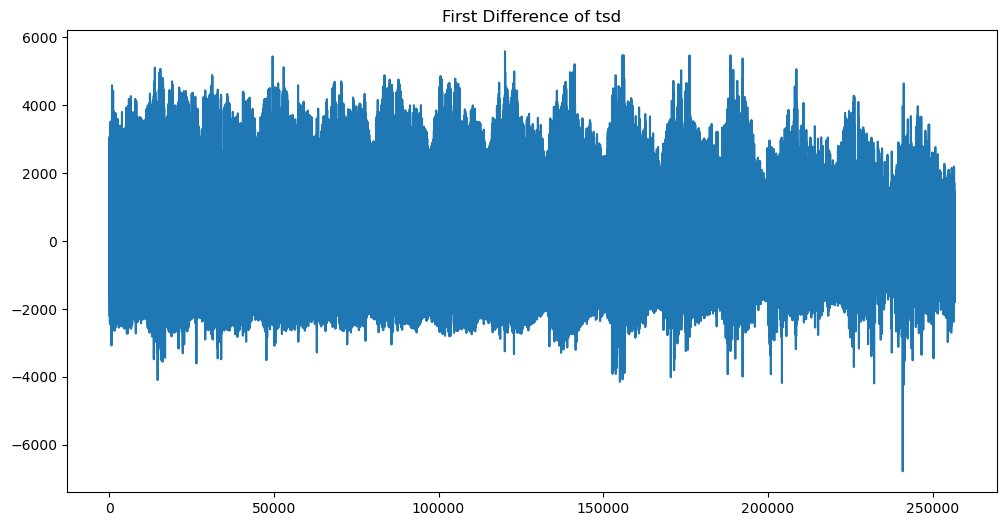

In [6]:
plt.figure(figsize=(12, 6))
data_loaded['tsd_diff'].plot(title='First Difference of tsd')
plt.show()

### 3.5 Re-run ADF and KPSS test on tsd_diff

In [7]:
adf_result_diff = adfuller(data_loaded['tsd_diff'].dropna())
print('ADF Statistic (Difference Data):', adf_result_diff[0])
print('p-value:', adf_result_diff[1])

ADF Statistic (Difference Data): -66.06649322169788
p-value: 0.0


In [8]:
kpss_result_diff = kpss(data_loaded['tsd_diff'].dropna())
print('KPSS Statistic (Difference Data):', kpss_result_diff[0])
print('p-value:', kpss_result_diff[1])
print('Critical Values:', kpss_result_diff[3])

KPSS Statistic (Difference Data): 0.0007534262677409369
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Let's interpret these results:

##### ADF Test (on Differenced Data):

- **ADF Statistic**: \(-66.06649322169788\) is highly negative.
- **p-value**: 0.0 is essentially 0.

**Interpretation**: The ADF test suggests that the differenced series is stationary, as the p-value is significantly less than the commonly used significance level (0.05).

##### KPSS Test (on Differenced Data):

- **KPSS Statistic**: \(0.0007534262677409369\) is way below the critical values.
- **p-value**: 0.1 is above the common significance levels.

**Interpretation**: Given the p-value(<0.05) and the KPSS statistic being below the critical values, we fail to reject the null hypothesis. This suggests that the differenced series is stationary around a deterministic trend.

In conclusion, both tests agree that after taking the first difference, our time series data is stationary. This is good news for most time series forecasting techniques, as many of them require or at least perform better when the data is stationary.

The next step involves choosing and fitting a forecasting model to the differenced (stationary) data, like ARIMA or SARIMA. 

## 4. Selecting a Model

Since our data has a seasonal component and has been differenced to achieve stationarity, a Seasonal ARIMA (SARIMA) model would be a suitable choice. SARIMA allows for both non-seasonal (p, d, q) and seasonal (P, D, Q, S) components.

### 4.1 Model Order Selection
To determine the optimal Non-seasonal orders: (p, d, q) and Seasonal orders:(P, D, Q, s) parameters, we can utilize tools like the auto_arima function from the pmdarima library, which conducts a search over possible model orders and chooses the best.

**Note**:
- Non-seasonal orders                                  
     - p:autoregressive order
     - d:differencing order
     - q:moving averge order
     
- Seasonal orders                                  
     - P:seasonal autoregressive order
     - D:seasonal differencing order
     - Q:seasonal moving averge order   
     - s:number of time steps per cycle

**Note:**

We will use the pmdarima: This is a third-party library that provides the auto_arima function, among other utilities. auto_arima helps in determining the best ARIMA/SARIMA parameters (p, d, q, P, D, Q, s) by trying out a range of values and selecting the one with the lowest AIC. Essentially, it's a useful tool for hyperparameter tuning for ARIMA/SARIMA models.

Given the computational constraints. We will impose limitation of our SARIMA model parameters and instead choose a range of values. See below:

The parameters for the ARIMA and SARIMA models are typically chosen based on the data's characteristics and domain knowledge. However, for an exploratory or automated approach like auto_arima, there are commonly-used ranges:

- **p, d, q (Non-seasonal parameters)**:

    - p (lag order of AR term): This denotes lags of dependent variable. For a time series that shows a slower-moving trend, we might start with a range like start_p=0 and max_p=3.
    - d (degree of differencing): We've already differenced the data, so we can set d=0. But generally, d is between 0 and 2.
    - q (lag order of MA term): This is about the lags of the forecast errors. A common range might be start_q=0 and max_q=3.
    
- **P, D, Q, m (Seasonal parameters)**:

    - P (seasonal autoregressive order): For daily data with multiple intra-day data points, starting at start_P=0 and max_P=2 is reasonable.
    - D (seasonal differencing order): Since we're using daily data and there seems to be a seasonal component, this could be set to 1. But in auto_arima, we can keep it as default and let it decide.
    - Q (seasonal moving average order): As with q, a starting point could be start_Q=0 and max_Q=2.
    - m (number of periods in season): As we've pointed out, for our half-hourly data, m=48.
- **Other parameters**:

    - trace=True: To view intermediate results.
    - error_action='ignore': Don't want to know if an order does not work.
    - suppress_warnings=True: Don't want convergence warnings.
    - stepwise=True: To apply the stepwise algorithm to search for the best order.

#### Computational Constraints

Due to computational constraints we will subset the most recent 1000 data points from the dataset.

In [11]:
subset_data = data_loaded.iloc[-1000:].copy()
subset_data.shape

(1000, 20)

#### 4.1.1. Split the Dataset in Train and Test test

In [12]:
# Splitting the data at the 80% mark
split_point = int(0.8 * len(subset_data))
train = subset_data[:split_point]
test = subset_data[split_point:]

print(f"Training set has {len(train)} data points.")
print(f"Test set has {len(test)} data points.")

Training set has 800 data points.
Test set has 200 data points.


### Determine SARIMAX Parameters using `auto_arima( )`

In [13]:
# Proceed with the auto_arima function on train dataset
from pmdarima import auto_arima

# Set d=0 because data is already differenced
sarima_order = auto_arima(train['tsd_diff'].dropna(), seasonal=True, m=48,
                          start_p=0, start_q=0, max_p=3, max_q=3,
                          start_P=0, max_P=2, start_Q=0, max_Q=2,
                          trace=True, error_action='ignore', suppress_warnings=True,
                          stepwise=True, d=0, D=1, n_jobs=-1)

print(sarima_order.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[48] intercept   : AIC=11377.421, Time=0.37 sec
 ARIMA(1,0,0)(1,1,0)[48] intercept   : AIC=11129.534, Time=10.23 sec
 ARIMA(0,0,1)(0,1,1)[48] intercept   : AIC=inf, Time=17.69 sec
 ARIMA(0,0,0)(0,1,0)[48]             : AIC=11375.425, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[48] intercept   : AIC=11308.261, Time=1.79 sec
 ARIMA(1,0,0)(2,1,0)[48] intercept   : AIC=11086.755, Time=28.76 sec
 ARIMA(1,0,0)(2,1,1)[48] intercept   : AIC=inf, Time=57.72 sec
 ARIMA(1,0,0)(1,1,1)[48] intercept   : AIC=inf, Time=23.05 sec
 ARIMA(0,0,0)(2,1,0)[48] intercept   : AIC=11186.854, Time=25.53 sec
 ARIMA(2,0,0)(2,1,0)[48] intercept   : AIC=11083.782, Time=37.84 sec
 ARIMA(2,0,0)(1,1,0)[48] intercept   : AIC=11129.363, Time=14.55 sec
 ARIMA(2,0,0)(2,1,1)[48] intercept   : AIC=inf, Time=80.76 sec
 ARIMA(2,0,0)(1,1,1)[48] intercept   : AIC=inf, Time=36.58 sec
 ARIMA(3,0,0)(2,1,0)[48] intercept   : AIC=11084.632, Time=42.09 sec
 ARIMA(2,0,1)(2,1,0)[48]

**Note**: 

- **n_jobs=-1**: means all CPUs are used
- **d=0**:- We've already differenced the series once manually, which is why we set d=0 in the auto_arima function, indicating that no further non-seasonal differencing is required.
- **D=1**: This accounts for daily seasonality in our data by differencing the series with a lag of 48 observations (i.e., one day). This is assuming there's a daily seasonality in the data that we need to account for.
    - To put it simply, d deals with the overall trend in the series, whereas D deals with the repeating patterns arising at fixed intervals (seasonality).


Once we've run the above code, the summary will provide the order (p, d, q) and seasonal order (P, D, Q, S) that were found to be the best for our dataset.

#### Results Interpretation:

- From the results, the model with the lowest AIC value (which generally indicates a better model fit given the trade-off between goodness of fit and model complexity) is the ARIMA(1,0,1)(2,1,0)[48] with an AIC of 11081.192. This suggests that this model would be the most suitable for our time series data among the models that were tried.

We will then fit a SARIMA model with the parameters:
- Non-seasonal orders:
    - p=1, d=0, q=1, 
    
- Seasonal orders:
    - P=2, D=1, Q=0
- Other parameters:
    - m = 48 - seasonal period

### 5.2 Fit SARIMA Model & Training

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Using the parameters from auto_arima
model = SARIMAX(train['tsd_diff'].dropna(), 
                order=(1, 0, 1), 
                seasonal_order=(2, 1, 0, 48),
                enforce_stationarity=False,
                enforce_invertibility=False)

fitted_model = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03770D+00    |proj g|=  2.86063D-02

At iterate    5    f=  6.03606D+00    |proj g|=  9.65641D-03

At iterate   10    f=  6.03576D+00    |proj g|=  5.17199D-04

At iterate   15    f=  6.03552D+00    |proj g|=  1.02373D-02

At iterate   20    f=  6.02109D+00    |proj g|=  5.70027D-02

At iterate   25    f=  6.01596D+00    |proj g|=  3.57589D-04

At iterate   30    f=  6.01596D+00    |proj g|=  9.93783D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

### SARIMAX Results Interpretation

These results indicate that the optimizer used by the SARIMAX model, L-BFGS-B in this case, has converged successfully. Here's a brief breakdown of the important points:

1. **CONVERGENCE**: The fact that we see the line `CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL` suggests that the optimization process met its convergence criteria. Specifically, the norm of the projected gradient is less than or equal to the pre-defined tolerance `PGTOL`.

2. **Iterations and Function Evaluations**: The optimizer took 30 iterations (`Tit`) and 36 function evaluations (`Tnf`) to converge. This is a good sign because it didn't hit the maximum number of iterations or function evaluations, suggesting it found a solution within a reasonable number of attempts.

3. **Final Function Value**: The final function value (`F`) of 6.016 indicates the value of the objective function (in this context, the likelihood function) that the SARIMAX model is trying to maximize. This number in isolation may not mean much, but it's useful if we're comparing different models or parameters.

4. **Projected Gradient**: A very small value for the norm of the projected gradient (`Projg`) is a good sign. This suggests that the optimizer has reached a point where making any further small changes to the parameters will not significantly improve the objective function. This is one of the convergence criteria.

**Note**:
Now, with the model fitted, the next steps are:

1. **Validation**: Use the model to generate forecasts for the test set and calculate error metrics to gauge how well the model predicts unseen data.
2. **Model Diagnostics**: Examine diagnostic plots (e.g., residuals over time, histogram of residuals, Q-Q plot, and the autocorrelation function of residuals) to determine if there are any patterns that the model failed to capture.
3. **Forecasting**: Use the model to make forecasts for future data points beyond our current dataset.

Given this convergence, we're in a good spot to proceed with the validation and further analyses.

### 5.3 Validation

**Validation**: We'll generate in-sample predictions for the training data and out-of-sample forecasts for the test set. This allows us to visually compare how well our model fits the training data and how well it forecasts unseen data. Additionally, we'll compute some error metrics to quantify the accuracy of the forecasts.

In [15]:
# In-sample predictions
train_predictions = fitted_model.get_prediction(start=0, end=len(train)-1, dynamic=False)
train_pred_mean = train_predictions.predicted_mean
train_pred_ci = train_predictions.conf_int()

# Out-of-sample forecasts
forecast = fitted_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

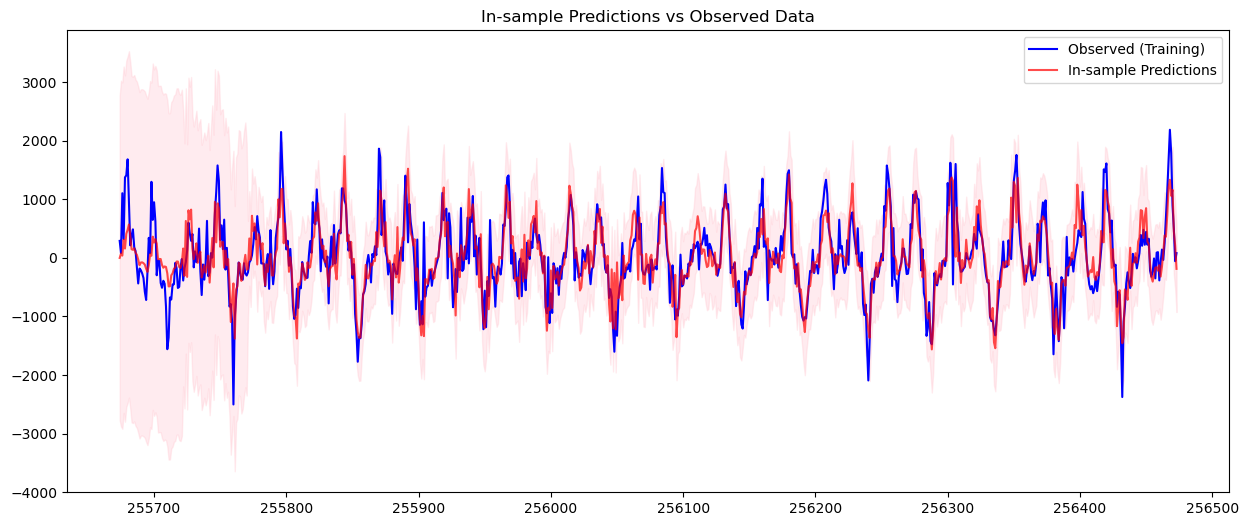

In [16]:
import matplotlib.pyplot as plt

# 1. Plotting In-sample Predictions
plt.figure(figsize=(15, 6))

# Plot the training data
plt.plot(train.index, train['tsd_diff'], label='Observed (Training)', color='blue')

# Plot the predicted values
plt.plot(train.index, train_pred_mean, label='In-sample Predictions', color='red', alpha=0.7)

# Plot the confidence intervals
plt.fill_between(train_pred_ci.index, train_pred_ci.iloc[:, 0], train_pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('In-sample Predictions vs Observed Data')
plt.legend()
plt.show()

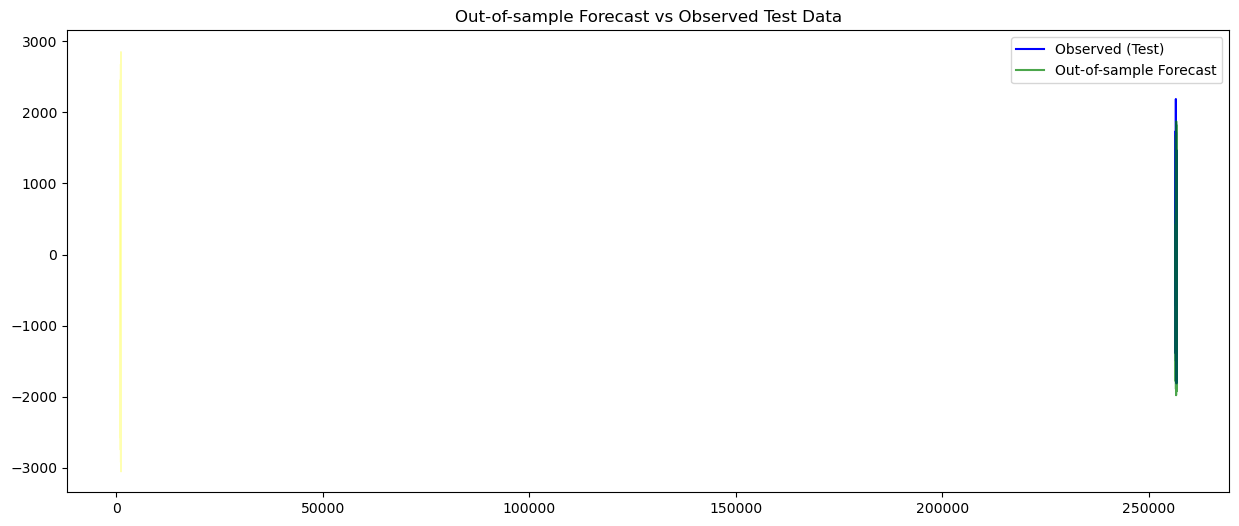

In [17]:
# 2. Plotting Out-of-sample Forecasts
plt.figure(figsize=(15, 6))

# Plot the test data
plt.plot(test.index, test['tsd_diff'], label='Observed (Test)', color='blue')

# Plot the forecasted values
plt.plot(test.index, forecast_mean, label='Out-of-sample Forecast', color='green', alpha=0.7)

# Plot the confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='yellow', alpha=0.3)

plt.title('Out-of-sample Forecast vs Observed Test Data')
plt.legend()
plt.show()

#### Visual Results Interpretation

These plots give us a visual representation of how the model performed on the training data and how well it's forecasting the test data. Remember, the closer the predictions and forecasts are to the actual observed data, the better our model is performing. This shows that our model us performing well.

### 6.0 Model Evaluation

In [19]:
# Check if there are missing values in the test set or forecast
print(test['tsd_diff'].isnull().sum())
print(np.isnan(forecast_mean).sum())

0
0


In [20]:
# Check the length of forecasted points and actual test points
print(len(test['tsd_diff']))
print(len(forecast_mean))

200
200


In [22]:
print(forecast_mean.head())

800    -262.553100
801    -361.409254
802   -1137.732783
803    -805.197212
804    -672.335778
Name: predicted_mean, dtype: float64


In [23]:
print(forecast_mean.index)

RangeIndex(start=800, stop=1000, step=1)


**Note**: Addressing MAE NaN vaues

The index for forecast_mean starts at 800 and goes up to 1000. This means that we're trying to align test['tsd_diff'], which starts with an index at 0 with forecast_mean, which starts with an index of 800.

Therefore, what's probably happening is when we try to subtract forecast_mean from test['tsd_diff'], pandas attempts to align the two Series based on their indices. Given the discrepancy in indexing, this leads to a misalignment, resulting in NaN values in the resultant Series. This is why we're getting MAE: nan.

    - RMSE: 411.2693986482061
    - MAE: nan

To fix this, we should reset the index of both Series to ensure they align correctly.

We will calculate the following evaluation metrics:

- **RMSE**: gives us an idea of how much error the model makes in its predictions, with a higher weight to large errors.

- **MAE**: measures the average magnitude of the errors between predicted and observed values without considering their direction.

In [26]:
test = subset_data[split_point:]
test = test.reset_index(drop=True)

In [27]:
print("NaN values in test['tsd_diff']:", test['tsd_diff'].isna().sum())


NaN values in test['tsd_diff']: 0


In [28]:
# Reset the index without adding the old index as a column
test['tsd_diff_reset'] = test['tsd_diff'].reset_index(drop=True)
forecast_mean_reset = forecast_mean.reset_index(drop=True)

In [29]:
print("NaN values in test['tsd_diff_reset']:", test['tsd_diff_reset'].isna().sum())
print("NaN values in forecast_mean_reset:", forecast_mean_reset.isna().sum())

NaN values in test['tsd_diff_reset']: 0
NaN values in forecast_mean_reset: 0


In [30]:
from sklearn.metrics import mean_squared_error

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['tsd_diff'], forecast_mean_reset))
mae = np.mean(np.abs(test['tsd_diff'] - forecast_mean_reset))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 411.2693986482061
MAE: 318.05827659443133


#### Results Interpretation

- RMSE (Root Mean Squared Error): 411.27
    - This metric gives an idea about how far, on average, our predictions are from the actual values. 
    - The RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

- MAE (Mean Absolute Error): 318.06
    - The MAE measures the average magnitude of the errors between predicted and observed values. 
    - The advantage of MAE is that it doesn't consider the direction of the error and treats all individual differences in the same way, be it positive or negative.
    
- On average, our model's forecasts are off by about 318 units (using MAE) and 411.27 units using (RMSE).
- The RMSE indicates that larger errors have a disproportionately large impact on the model's overall error.

### 7.0 Forecasting

The `forecast()` function of the SARIMAX results object can be used to make forecasts. 

In [34]:
# Forecasting the next 'n' steps
n_steps = 48 # the next 48 data points or 24 hours
forecasted_values = fitted_model.forecast(steps=n_steps)

### 7.1 Plotting Forecast

**Note**: We visualize the forecasts along with the actual values to get a sense of how well the model is capturing future patterns.

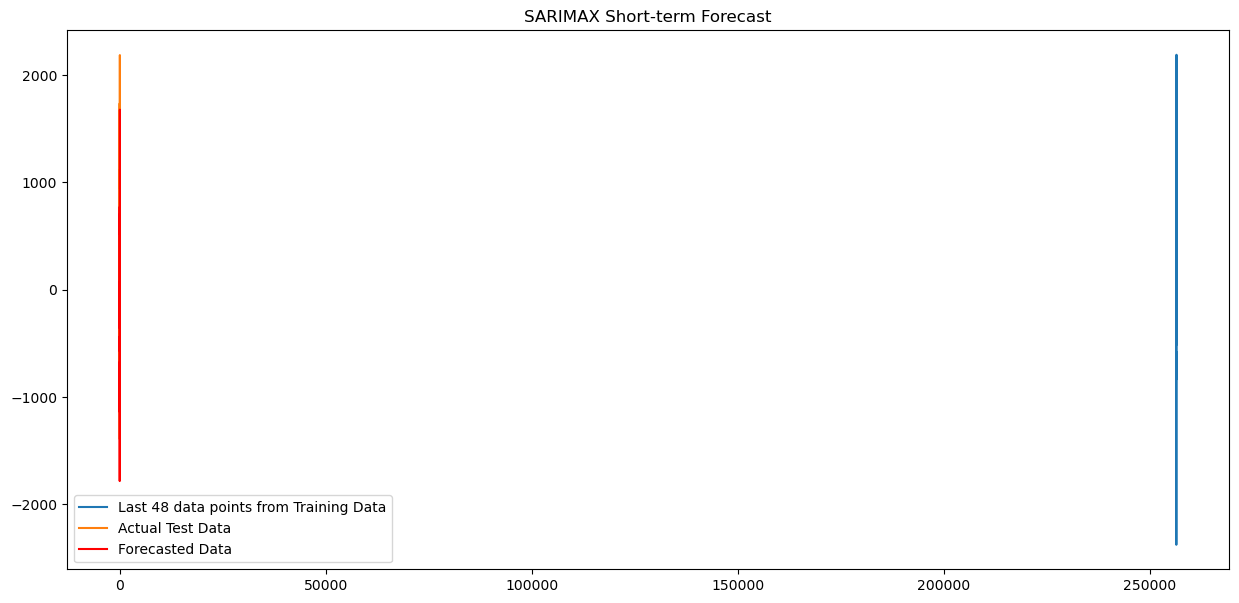

In [35]:
import matplotlib.pyplot as plt

# Plotting actual vs. forecasted values
plt.figure(figsize=(15, 7))

# Plotting the end of the training data
plt.plot(train.index[-n_steps:], train['tsd_diff'].tail(n_steps), label='Last 48 data points from Training Data')

# Plotting the start of the test data
plt.plot(test.index[:n_steps], test['tsd_diff'].head(n_steps), label='Actual Test Data')

# Plotting the forecasted values
plt.plot(test.index[:n_steps], forecasted_values, label='Forecasted Data', color='red')

plt.legend(loc='best')
plt.title('SARIMAX Short-term Forecast')
plt.show()

**Results Interpretation**:

- The forecasted data (in red ) stays close to the actual test data, especially in the early parts of the forecast (the beginning steps). 
- As we move further into the forecast (towards the end of the 48 data points), we may expect the forecast to potentially diverge more from the test data since predicting further into the future is generally more uncertain. However, it is difficult to see that visually.
-  Any discrepancies between the forecasted line and the actual test data line highlight areas where the model's predictions were off. We don't see that here.

### Conclusion
- How good or bad is our model? That depends on whether being off by 25% of the data is acceptable or not.
- Our SARIMA model's RMSE (411.27) represents less than 1% of our data range (43,634) which implies that, on average, the SARIMA model's predictions are off by about 411.27 units from the actual values.
- This means that our SARIMA model is significantly more accurate in its predictions that the prophet model, given its much lower RMSE value.
    - This can be explained by the fact that the SARIMA, being tailored for time series with clear seasonality and trends, is able to capture the underlying patterns in our electricity demand data better than Prophet. 

- Therefore, given the stark difference in RMSE, if we had to choose a model based solely on this metric, the SARIMA model would be the preferred choice for forecasting electricity demand in Great Britain for this particular dataset.